In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
import rec_utils
from resnet import resnet
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


# Load data

In [4]:
data = np.load("../data/test_data_100.npy").astype('float32')
label = np.load("../data/test_label_100.npy").astype('float32')
n, n_c = label.shape[0], label.shape[1]

# Load model

In [5]:
model_path = "../models/resnet29_cifar10.h5"
input_shape = data.shape[1:]
model = resnet(input_shape=input_shape, depth=29, num_classes=n_c).build()
model.load_weights(model_path)

# Parameters test

## delta, mu

In [6]:
data_rec = np.load("../results/data_rec_d_u.npy")
psnrs = np.load("../results/psnrs_d_u.npy")

In [7]:
print(data_rec.shape, psnrs.shape)

(100, 10, 10, 32, 32, 3) (100, 10, 10)


In [8]:
mean_psnrs = np.mean(psnrs, axis=0)

In [9]:
deltas = np.arange(0.01, 0.11, 0.01)
mus = np.arange(0.01, 0.11, 0.01)

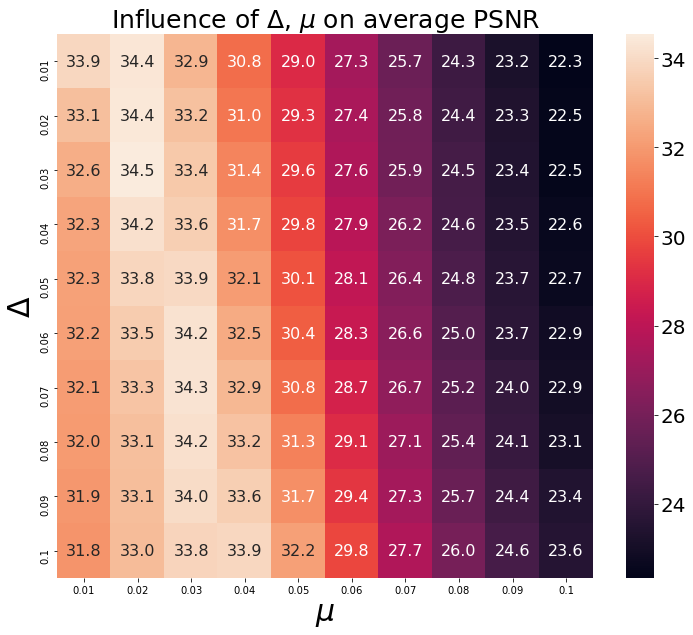

In [10]:
df_cm = pd.DataFrame(mean_psnrs, index=np.around(deltas, decimals=2), columns=np.around(mus, decimals=2))
plt.figure(figsize=(12,10))
ax = sn.heatmap(df_cm, annot=True, fmt='.1f', annot_kws={'size':16})
cax = plt.gcf().axes[-1] 
cax.tick_params(labelsize=20)

plt.title(r"Influence of $\Delta$, $\mu$ on average PSNR", fontsize=25)
plt.xlabel(r"$\mu$", fontsize=30)
plt.ylabel(r"$\Delta$", fontsize=30)
plt.show()

In [11]:
data_rec[:, 0, 0, :, :, :].shape

(100, 32, 32, 3)

In [12]:
acc_d_u = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        pred = model.predict(data_rec[:, i, j])
        acc = rec_utils.accuracy(pred, label)
        acc_d_u[i, j] = acc

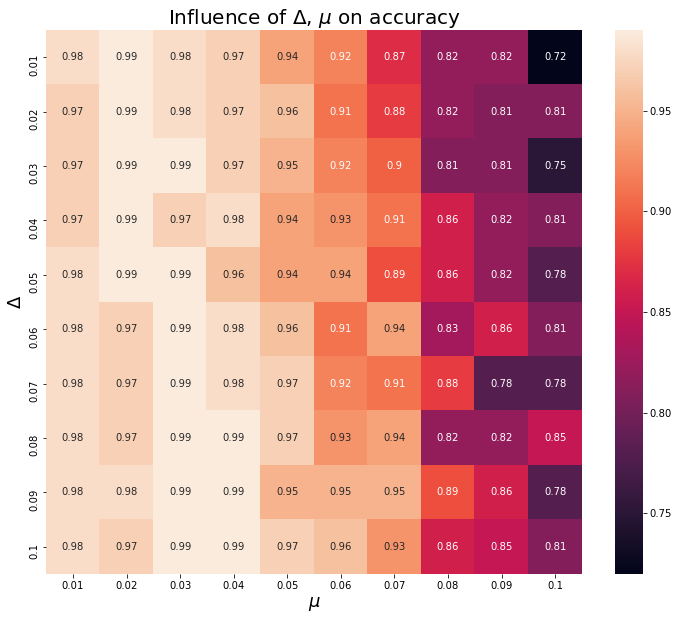

In [13]:
df_cm = pd.DataFrame(acc_d_u, index=np.around(deltas, decimals=2), columns=np.around(mus, decimals=2))
plt.figure(figsize=(12,10))
ax = sn.heatmap(df_cm, annot=True)
plt.title(r"Influence of $\Delta$, $\mu$ on accuracy", fontsize=20)
plt.xlabel(r"$\mu$", fontsize=18)
plt.ylabel(r"$\Delta$", fontsize=18)
plt.show()

## Window size

In [14]:
data_rec_ws = np.load("../results/data_rec_ws.npy")
psnrs_ws = np.load("../results/psnrs_ws.npy")

In [15]:
print(data_rec_ws.shape, psnrs_ws.shape)

(100, 5, 32, 32, 3) (100, 5)


In [22]:
mean_psnrs_ws = np.mean(psnrs_ws, axis=0)

In [23]:
window_sizes = [2, 4, 8, 16, 32]

In [25]:
acc_ws = np.zeros(5)
for i in range(5):
    pred = model.predict(data_rec_ws[:, i])
    acc = rec_utils.accuracy(pred, label)
    acc_ws[i] = acc

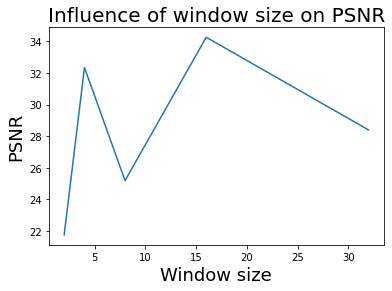

In [26]:
plt.plot(window_sizes, mean_psnrs_ws)
plt.title(r"Influence of window size on PSNR", fontsize=20)
plt.xlabel("Window size", fontsize=18)
plt.ylabel("PSNR", fontsize=18)
plt.show()

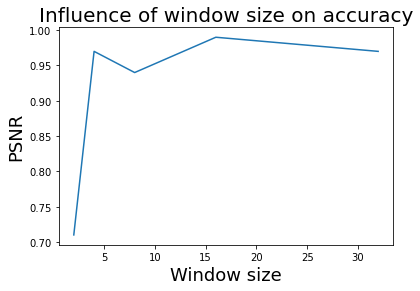

In [27]:
plt.plot(window_sizes, acc_ws)
plt.title(r"Influence of window size on accuracy", fontsize=20)
plt.xlabel("Window size", fontsize=18)
plt.ylabel("PSNR", fontsize=18)
plt.show()

# AE test

In [28]:
ratio = 0.1
delta = 0.03
mu = 0.02
ws = 8

In [ ]:
accs = np.zeros((10))
for d in range(10):
    data_rec = np.zeros((n, 32, 32, 3))
    for i in range(n):
        test_img_drop, test_drop_map = rec_utils.random_drop(data[i], ws, ratio)
        test_img_rec = rec_utils.recovery_iter(test_img_drop, test_drop_map, ws, delta, mu, max_iters=100)
        data_rec[i] = test_img_rec
    pred = model.predict(data_rec)
    acc = rec_utils.accuracy(pred, label)
    accs[d] = acc

In [ ]:
ratios = np.arange(0.05, 1.0, 0.05)
for ratio in ratios:
    for d in range(10):
        data_rec = np.zeros((n, 32, 32, 3))
        for i in range(n):
            test_img_drop, test_drop_map = rec_utils.random_drop(data[i], ws, ratio)
            test_img_rec = rec_utils.recovery_iter(test_img_drop, test_drop_map, ws, delta, mu, max_iters=100)
            data_rec[i] = test_img_rec
        pred = model.predict(data_rec)
        acc = rec_utils.accuracy(pred, label)
        accs[d] = acc
    print(ratio, accs, np.mean(accs))

In [ ]:
ae_path = "../ae/ae_ifgsm_0.005_100.npy"
ae_data = np.load(ae_path)

In [ ]:
test_id = 1
test_img = data[test_id]
ae_img = ae_data[test_id]
plt.imshow(test_img)
plt.show()
plt.imshow(ae_img)
plt.show()

In [ ]:
pred = model.predict(ae_data)
acc = rec_utils.accuracy(pred, label)
acc

In [ ]:
print(rec_utils.linf_distortion(data, ae_data))
print(rec_utils.l2_distortion(data, ae_data))

In [ ]:
ratios = np.arange(0.05, 0.5, 0.05)
for ratio in ratios:
    data_rec = np.zeros((n, 32, 32, 3))
    for i in range(n):
        test_img_drop, test_drop_map = rec_utils.random_drop(ae_data[i], ws, ratio)
        test_img_rec = rec_utils.recovery_iter(test_img_drop, test_drop_map, ws, delta, mu, max_iters=100)
        data_rec[i] = test_img_rec
    pred = model.predict(data_rec)
    acc = rec_utils.accuracy(pred, label)
    print(ratio, acc)

In [ ]:
test_id = 1
test_img = selected_test_data[test_id]
ae_img = ae_data[test_id]
plt.imshow(test_img)
plt.show()
plt.imshow(ae_img)
plt.show()
print(linf_distortion(test_img, ae_img))
print(l2_distortion(test_img, ae_img))

# Pixel deflection

In [384]:
from random import randint
from skimage.restoration import denoise_wavelet

In [68]:
def pixel_deflection(img, deflections, window):
    H, W, C = img.shape
    img = img.copy()
    while deflections > 0:
        for c in range(C):
            x, y = randint(0, H-1), randint(0, W-1)

            while True: #this is to ensure that PD pixel lies inside the image
                a, b = randint(-1*window, window), randint(-1*window, window)
                if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
            img[x, y, c] = img[x+a, y+b, c]
            deflections -= 1
    return img

In [100]:
def pd_defense(data, ratio):
    pd_data = np.zeros(data.shape)
    for i in range(data.shape[0]):
        img = pixel_deflection(data[i], deflections=np.round(32 * 32 * ratio), window=8)
        # img = pixel_deflection(data[i], deflections=10, window=8)
        pd_data[i] = denoise_wavelet(img, multichannel=True, convert2ycbcr=True,
                                     method='BayesShrink', mode='soft')

    return pd_data

In [101]:
pd_data = pd_defense(data, ratio=0.1)

In [102]:
accs = np.zeros((10))
for d in range(10):
    pd_pred = model.predict(pd_data)
    acc = rec_utils.accuracy(pd_pred, label)
    accs[d] = acc

In [103]:
np.mean(accs)

0.93

In [104]:
ae_dir = "../ae"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        ae_data = np.load(path)
        print(path)
        ratios = np.arange(0.05, 0.95, 0.05)
        for ratio in ratios:
            pd_ae_data = pd_defense(ae_data, ratio)
            accs = np.zeros((10))
            for d in range(10):
                pd_ae_pred = model.predict(pd_ae_data)
                acc = rec_utils.accuracy(pd_ae_pred, label)
                accs[d] = acc
            print(ratio, np.mean(accs))

../ae/ae_cw_100.npy
0.05 0.9
0.1 0.85
0.15000000000000002 0.75
0.2 0.8400000000000001
0.25 0.6899999999999998
0.3 0.72
0.35000000000000003 0.6399999999999999
0.4 0.63
0.45 0.55
0.5 0.53
0.55 0.5199999999999999
0.6000000000000001 0.4
0.6500000000000001 0.44000000000000006
0.7000000000000001 0.4699999999999999
0.7500000000000001 0.45
0.8 0.42000000000000004
0.8500000000000001 0.4600000000000001
0.9000000000000001 0.38
../ae/ae_lbfgs_100.npy
0.05 0.9600000000000002
0.1 0.86
0.15000000000000002 0.82
0.2 0.8
0.25 0.8
0.3 0.6799999999999999
0.35000000000000003 0.66
0.4 0.5700000000000001
0.45 0.62
0.5 0.5600000000000002
0.55 0.51
0.6000000000000001 0.5199999999999999
0.6500000000000001 0.5600000000000002
0.7000000000000001 0.45
0.7500000000000001 0.41
0.8 0.4
0.8500000000000001 0.29999999999999993
0.9000000000000001 0.44000000000000006
../ae/ae_deepfool_100.npy
0.05 0.93
0.1 0.9
0.15000000000000002 0.79
0.2 0.75
0.25 0.72
0.3 0.72
0.35000000000000003 0.6399999999999999
0.4 0.6399999999999999

In [105]:
ratios = np.arange(0.05, 0.95, 0.05)
for ratio in ratios:
    pd_ae_data = pd_defense(data, ratio)
    accs = np.zeros((10))
    for d in range(10):
        pd_ae_pred = model.predict(pd_ae_data)
        acc = rec_utils.accuracy(pd_ae_pred, label)
        accs[d] = acc
    print(ratio, np.mean(accs))

0.05 0.9600000000000002
0.1 0.9399999999999998
0.15000000000000002 0.8400000000000001
0.2 0.79
0.25 0.74
0.3 0.74
0.35000000000000003 0.63
0.4 0.63
0.45 0.6100000000000001
0.5 0.5999999999999999
0.55 0.53
0.6000000000000001 0.5199999999999999
0.6500000000000001 0.5
0.7000000000000001 0.4800000000000001
0.7500000000000001 0.45
0.8 0.4699999999999999
0.8500000000000001 0.41
0.9000000000000001 0.33


# Reconstruction + WD

In [66]:
ratios = np.arange(0.05, 0.5, 0.05)
for ratio in ratios:
    data_rec = np.zeros((n, 32, 32, 3))
    for i in range(n):
        test_img_drop, test_drop_map = rec_utils.random_drop(ae_data[i], ws, ratio)
        test_img_rec = rec_utils.recovery_iter(test_img_drop, test_drop_map, ws, delta, mu, max_iters=100)
        data_rec[i] = denoise_wavelet(test_img_rec, multichannel=True, convert2ycbcr=True,
                                      method='BayesShrink', mode='soft')
    pred = model.predict(data_rec)
    acc = rec_utils.accuracy(pred, label)
    print(ratio, acc)

0.05 0.54
0.1 0.65
0.15000000000000002 0.78
0.2 0.79
0.25 0.79
0.3 0.71
0.35000000000000003 0.72
0.4 0.64
0.45 0.54


In [75]:
ae_dir = "../ae"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        print(path)
        ae_data = np.load(path)
        ratios = [0.01] # np.arange(0.5, 0.95, 0.05)
        for ratio in ratios:
            data_rec = np.zeros((n, 32, 32, 3))
            for i in range(n):
                test_img_drop, test_drop_map = rec_utils.random_drop(ae_data[i], ws, ratio)
                test_img_rec = rec_utils.recovery_iter(test_img_drop, test_drop_map, ws, delta, mu, max_iters=100)
                data_rec[i] = denoise_wavelet(test_img_rec, multichannel=True, convert2ycbcr=True,
                                              method='BayesShrink', mode='soft')
            pred = model.predict(data_rec)
            acc = rec_utils.accuracy(pred, label)
            print(ratio, acc)

../ae/ae_cw_100.npy
0.01 0.98
../ae/ae_lbfgs_100.npy
0.01 0.95
../ae/ae_deepfool_100.npy
0.01 0.99
../ae/ae_ifgsm_0.005_100.npy
0.01 0.45
../ae/ae_pgd_0.01_100.npy
0.01 0.3
../ae/ae_mifgsm_0.005_100.npy
0.01 0.48
../ae/ae_fgsm_0.005_100.npy
0.01 0.6


In [76]:
ratios = [0.01] # np.arange(0.05, 0.5, 0.05)
for ratio in ratios:
    data_rec = np.zeros((n, 32, 32, 3))
    for i in range(n):
        test_img_drop, test_drop_map = rec_utils.random_drop(data[i], ws, ratio)
        test_img_rec = rec_utils.recovery_iter(test_img_drop, test_drop_map, ws, delta, mu, max_iters=100)
        data_rec[i] = denoise_wavelet(test_img_rec, multichannel=True, convert2ycbcr=True,
                                      method='BayesShrink', mode='soft')
    pred = model.predict(data_rec)
    acc = rec_utils.accuracy(pred, label)
    print(ratio, acc)

0.01 1.0


# Window size

In [30]:
window_sizes = [2, 4, 8, 16]

In [ ]:
acc_ws = np.zeros(4)
for d, ws in enumerate(window_sizes):
    data_rec = np.zeros((n, 32, 32, 3))
    for i in range(n):
        test_img_drop, test_drop_map = rec_utils.random_drop(data[i], ws, ratio=0.1)
        test_img_rec = rec_utils.recovery_iter(test_img_drop, test_drop_map, ws, delta, mu, max_iters=100)
        # data_rec[i] = denoise_wavelet(test_img_rec, multichannel=True, convert2ycbcr=True,
        #                              method='BayesShrink', mode='soft')
        data_rec[i] = test_img_rec
    pred = model.predict(data_rec)
    acc = rec_utils.accuracy(pred, label)
    print(ws, acc)
    acc_ws[d] = acc

In [ ]:
plt.plot(window_sizes, mean_psnrs_ws)
plt.title(r"Influence of window size on PSNR", fontsize=20)
plt.xlabel("Window size", fontsize=18)
plt.ylabel("PSNR", fontsize=18)
plt.show()

In [ ]:
plt.plot(window_sizes, acc_ws)
plt.title(r"Influence of window size on accuracy", fontsize=20)
plt.xlabel("Window size", fontsize=18)
plt.ylabel("PSNR", fontsize=18)
plt.show()

# eps

In [15]:
from skimage.measure import compare_mse, compare_psnr

In [337]:
def recovery_iter(img_drop, drop_map, ws, delta, mu, eps=1e-06, max_iters=100):
    mses = np.zeros(max_iters)
    psnrs = np.zeros(max_iters)
    deltas = np.zeros(max_iters)
    mus = np.zeros(max_iters)

    max_mse = 0
    gamma = 0.01
    img_rec_0 = img_drop.copy()
    img_rec = np.zeros(img_drop.shape)
    for i in range(max_iters):
        for c in range(3):
            img_rec[:, :, c] = rec_utils.image_recovery(img_rec_0[:, :, c], drop_map, ws, delta, mu)
        img_rec = np.clip(img_rec, 0, 1)
        psnr = compare_psnr(img, img_rec)
        mse = compare_mse(img_rec_0, img_rec)
        if mse > max_mse:
            max_mse = mse
        elif mse < gamma * max_mse:
            delta /= 10
            mu /= 10
            #if mse < eps:
            #    break
            max_mse = mse

        img_rec_0 = img_rec.copy()
        mses[i], psnrs[i], deltas[i], mus[i] = mse, psnr, delta, mu
        
    return img_rec, mses, psnrs, deltas, mus

In [338]:
i = 2
img = data[i]
test_img_drop, test_drop_map = rec_utils.random_drop(data[i], ws, ratio)
test_img_rec, mses, psnrs, deltas, mus = recovery_iter(test_img_drop, test_drop_map, ws, delta, mu, max_iters=50)

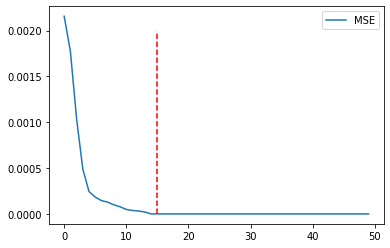

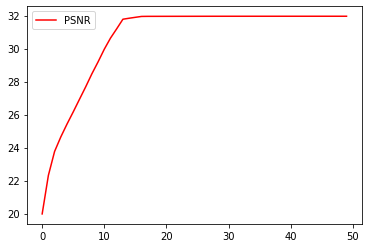

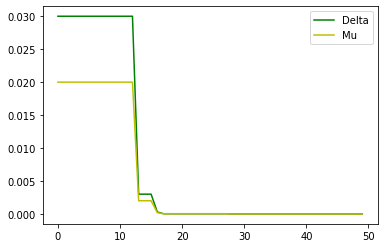

In [339]:
plt.plot(range(max_iters), mses, label='MSE')
plt.vlines(15, 0, 0.002, color="red", linestyle='--')
plt.legend()
plt.show()
plt.plot(range(max_iters), psnrs, color='r', label='PSNR')
plt.legend()
plt.show()
plt.plot(range(max_iters), deltas, color='g', label='Delta')
plt.plot(range(max_iters), mus, color='y', label='Mu')
plt.legend()
plt.show()

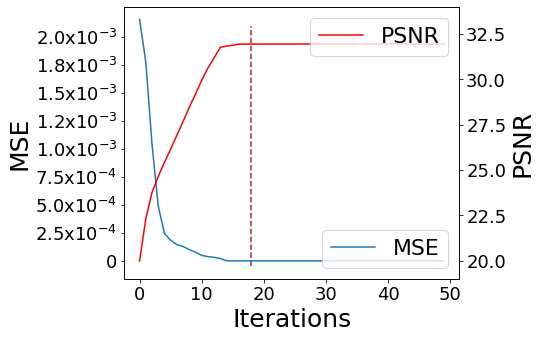

In [373]:
fig = plt.figure(figsize=(6, 5))
fs = 25
ax = fig.add_subplot(111)
ax.plot(range(max_iters), mses, label='MSE')
ax2 = ax.twinx()
ax2.plot(range(max_iters), psnrs, color='r', label='PSNR')
ax.vlines(18, -0.00005, 0.0021, color="brown", linestyle='--')
ax.legend(loc=4, fontsize=22)

def formatnum(x, pos):
    if x == 0:
        return 0
    if x >= 10**(-3):
        return '$%.1f$x$10^{-3}$' % (x * 1000)
    return '$%.1f$x$10^{-4}$' % (x * 10000)

formatter = FuncFormatter(formatnum)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Iterations", fontsize=fs)
ax.set_ylabel("MSE", fontsize=fs)
ax.tick_params(labelsize=18)
#x.set_ylim(-0.0001, 0.0023)
ax.set_yticks(np.linspace(0, 0.002, 9))

ax2.legend(loc=1, fontsize=22)
ax2.set_ylim(19, 34)
ax2.set_ylabel("PSNR", fontsize=fs)
ax2.tick_params(labelsize=18)
plt.show()

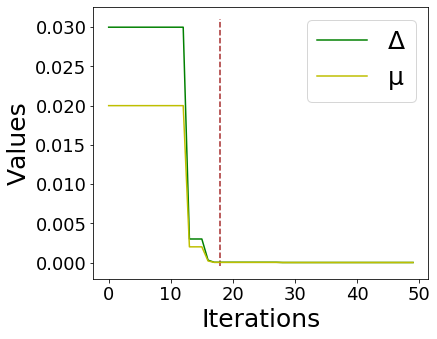

In [376]:
plt.figure(figsize=(6, 5))
plt.plot(range(max_iters), deltas, color='g', label=r'$\Delta$')
plt.plot(range(max_iters), mus, color='y', label=r'$\mu$')
plt.vlines(18, -0.0005, 0.031, color="brown", linestyle='--')
plt.xlabel("Iterations", fontsize=fs)
plt.ylabel("Values", fontsize=fs)
plt.tick_params(labelsize=18)
plt.legend(fontsize=fs)
plt.show()

# BPDA

In [392]:
import tensorflow as tf
import keras.backend as K

In [393]:
def get_random_targets(label):
    result = np.zeros(label.shape[0])
    nb_s = label.shape[0]
    nb_classes = label.shape[1]

    for i in range(nb_s):
        result[i] = np.argmax(np.roll(label[i, :], randint(1, nb_classes - 1)))

    return result.astype(np.int64)

In [432]:
def bpda_attack(model, adv, label):
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    out = tf.log(model(x / 255.0))
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=out, labels=label)

    grads = tf.gradients(loss, [x])[0]
    grads = tf.sign(grads)

    sess = K.get_session()

    initial = adv.copy() * 255
    img = adv.copy() * 255
    for i in range(10):
        print(i)
        
        data_rec = np.zeros((n, 32, 32, 3))
        for i in range(n):
            test_img_drop, test_drop_map = rec_utils.random_drop(img[i] / 255, ws, ratio)
            test_img_rec = rec_utils.recovery_iter(test_img_drop, test_drop_map, ws, delta, mu, max_iters=100)
            data_rec[i] = test_img_rec
        res = data_rec * 255
        img -= sess.run(grads, {x: res})[:, :, :, :3]
        img = np.clip(img, initial - 2, initial + 2)
        img = np.clip(img, 0, 255)

    return img

In [433]:
random_label = get_random_targets(label)

In [434]:
bpda_data = bpda_attack(model, data, random_label)

0
1
2
3
4
5
6
7
8
9


In [435]:
bpda_pred = model.predict(bpda_data / 255)
print(rec_utils.accuracy(bpda_pred, label))

0.27


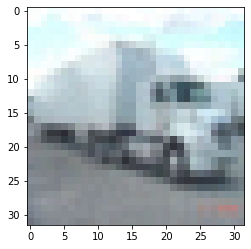

In [436]:
plt.imshow(bpda_data[0].astype('uint8'))

In [437]:
rec_utils.l2_distortion(data[0], bpda_data[0] / 255)

0.6509804129600525